In [1]:
import ROOT

Module libc not found.


Welcome to JupyROOT 6.30/09


In [2]:
ROOT.gSystem.Load('./RooBinnedGauss1d_cxx.so')

0

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from os.path import exists

import read_config_utils as cu

In [4]:
import sys
import time

import gc

In [5]:



input_dir = 'hist-pdf-toy-study-1d-2a-discretized-data-perfect'
#input_dir = 'hist-pdf-toy-study-1d-2a-discretized-data-goodres'
#input_dir = 'hist-pdf-toy-study-1d-2a-discretized-data-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-2a-discretized-data-mediumbad'

#---


points_file = 'train-and-true-samples.npy'





In [6]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [7]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 1




In [8]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)
    train_cov = np.load(f, allow_pickle=True)
    true_cov = np.load(f, allow_pickle=True)
    hist_pars = np.load(f, allow_pickle=True)
    discretize_hist_pars = np.load(f, allow_pickle=True)
    


In [9]:
discretize_hist_pars

array({'nbins': 60, 'xmin': -9.0, 'xmax': 9.0}, dtype=object)

In [10]:
discretize_hist_pars.item().get('nbins')

60

In [48]:
hist_xlow = discretize_hist_pars.item().get('xmin')
hist_xhigh = discretize_hist_pars.item().get('xmax')
hist_nbins = discretize_hist_pars.item().get('nbins')
hist_bin_edges = np.linspace( hist_xlow, hist_xhigh, hist_nbins+1 )
print('\n\n')
print(' hist pars:  xlow = %8.4f,  xhigh = %8.4f,   nbins = %d' % (hist_xlow, hist_xhigh, hist_nbins))
print(hist_bin_edges)




 hist pars:  xlow =  -9.0000,  xhigh =   9.0000,   nbins = 60
[-9.  -8.7 -8.4 -8.1 -7.8 -7.5 -7.2 -6.9 -6.6 -6.3 -6.  -5.7 -5.4 -5.1
 -4.8 -4.5 -4.2 -3.9 -3.6 -3.3 -3.  -2.7 -2.4 -2.1 -1.8 -1.5 -1.2 -0.9
 -0.6 -0.3  0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.4  2.7  3.   3.3
  3.6  3.9  4.2  4.5  4.8  5.1  5.4  5.7  6.   6.3  6.6  6.9  7.2  7.5
  7.8  8.1  8.4  8.7  9. ]


In [12]:
with open('%s/%s' % (input_dir, points_file),'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)


In [13]:
n_samples = 0

for fi in range(1000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 500 bootstrap samples.




## Read in the main OmniFold ouput for the fake data and fit it before doing the bootstraps

In [14]:
fname = '%s/omnifold-output-weights.npy' % (input_dir)
#fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, 0)  

print('\n\n Reading in %s for weights in test fit.\n\n' % fname)
with open(fname,'rb') as f :
    sample_weights = np.load(f)



 Reading in hist-pdf-toy-study-1d-2a-discretized-data-perfect/omnifold-output-weights.npy for weights in test fit.




In [15]:

nmcevts = len(train_pts)

print( "train_pts shape:  %s" % str(train_pts.shape))
print( "weights:  %s" % str(sample_weights.shape))

print( "number of MC events: %d" % nmcevts)

train_pts shape:  (100000, 1)
weights:  (100000,)
number of MC events: 100000


In [16]:


true_cov  = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d : diagonal  %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
   

   0,  0 : diagonal    0.8100


## Read in the simple calculation results to set the parameter limits

In [17]:
with open( '%s/simple-calc-results.npy' % input_dir, 'rb') as f :
    sc_ave_mean_val = np.load(f, allow_pickle=True )
    sc_ave_mean_rms = np.load(f, allow_pickle=True)
    sc_ave_cov_val  = np.load(f, allow_pickle=True)    
    sc_ave_cov_rms  = np.load(f, allow_pickle=True )



In [18]:
sc_ave_cov_val

array([[0.82064137]])

In [19]:
print('\n\n')
print('  Simple direct calculation results from the bootstrap samples.\n')

for fi in range(ndim) :
    print('  feature %d  mean:   %8.4f  (true %8.4f) RMS  %8.4f'
         % (fi, sc_ave_mean_val[fi], true_mu[fi], sc_ave_mean_rms[fi]) )
    
print('\n')

for i in range(ndim) :
    for j in range(i,ndim) :
        print('   %d, %d  cov:   %8.4f  (true %8.4f) RMS  %8.4f'
              % ( i, j, sc_ave_cov_val[i][j], true_cov[i,j], sc_ave_cov_rms[i][j]) )

print('\n\n')




  Simple direct calculation results from the bootstrap samples.

  feature 0  mean:     0.0620  (true   0.2000) RMS    0.0092


   0, 0  cov:     0.8206  (true   0.8100) RMS    0.0122





In [20]:
width_factor_mean = 10
width_factor_cov = 10

###  Do it this way to keep all the RooRealVars in memory in separate objects (different elements in the dictionary).

In [21]:
covdict = {}


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        startval = sc_ave_cov_val[i][j]
        minval = sc_ave_cov_val[i][j] - width_factor_cov * sc_ave_cov_rms[i][j]
        maxval = sc_ave_cov_val[i][j] + width_factor_cov * sc_ave_cov_rms[i][j]   
        print(' parameter %s  min %8.4f, max %8.4f' % (vname, minval, maxval))
        if ( i == j ) :
            ######covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], 0.02, 2.0 )           
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        else :
            ######covdict[vname] =   ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), true_cov[i][j], -1.1, 1.1 ) 
            covdict[vname] =  ROOT.RooRealVar( "cov%d%d" % (i,j), "cov%d%d" % (i,j), startval, minval, maxval )
        covdict[vname].Print()
        


 parameter cov00  min   0.6984, max   0.9429
RooRealVar::cov00 = 0.820641  L(0.698408 - 0.942875) 


In [22]:
covRAL = ROOT.RooArgList()


for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        vname = "cov%d%d" % (i,j)
        covRAL.add( covdict[vname] )


In [23]:
ralind = 0
for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        print( "  %d, %d :  %2d :  %s  %8.3f" % (i,j, ralind, covRAL.at(ralind).GetName(), covRAL.at(ralind).getVal() )) 
        ralind = ralind + 1

  0, 0 :   0 :  cov00     0.821


### The Dict keeps the variables defined in memory

In [24]:
xDict = {}
muDict = {}

xVec = ROOT.RooArgList()
muVec = ROOT.RooArgList()


for i in range(ndim) :
    vname = "x%d" % i
    xDict[vname] = ROOT.RooRealVar( vname, vname, 0., -10., 10. )
    xVec.add( xDict[vname] )
    vname = "mu_x%d" % i
    startval = sc_ave_mean_val[i]
    minval = sc_ave_mean_val[i] - width_factor_mean * sc_ave_mean_rms[i]
    maxval = sc_ave_mean_val[i] + width_factor_mean * sc_ave_mean_rms[i]
    print('  feature %d  mean :  min %8.4f, max %8.4f' % (i, minval, maxval))
    ##########muDict[vname] =  ROOT.RooRealVar( vname, vname, true_mu[i], -2., 2. )
    muDict[vname] =  ROOT.RooRealVar( vname, vname, startval, minval, maxval )
    muDict[vname].Print()
    muVec.add( muDict[vname] )
    
    
weight = ROOT.RooRealVar("weight","weight", 0., 100. )

  feature 0  mean :  min  -0.0303, max   0.1544
RooRealVar::mu_x0 = 0.0620494  L(-0.0302691 - 0.154368) 


In [25]:
#-- put these in dict to keep them in memory.
bin_edges_dict = {}
for bi in range( hist_nbins+1 ) :
    bin_name = 'bin_edge_%03d' % bi
    bin_edges_dict[bin_name] = ROOT.RooConstVar( bin_name, bin_name, hist_bin_edges[bi] )
    bin_edges_dict[bin_name].Print()

RooConstVar::bin_edge_000 = -9
RooConstVar::bin_edge_001 = -8.7
RooConstVar::bin_edge_002 = -8.4
RooConstVar::bin_edge_003 = -8.1
RooConstVar::bin_edge_004 = -7.8
RooConstVar::bin_edge_005 = -7.5
RooConstVar::bin_edge_006 = -7.2
RooConstVar::bin_edge_007 = -6.9
RooConstVar::bin_edge_008 = -6.6
RooConstVar::bin_edge_009 = -6.3
RooConstVar::bin_edge_010 = -6
RooConstVar::bin_edge_011 = -5.7
RooConstVar::bin_edge_012 = -5.4
RooConstVar::bin_edge_013 = -5.1
RooConstVar::bin_edge_014 = -4.8
RooConstVar::bin_edge_015 = -4.5
RooConstVar::bin_edge_016 = -4.2
RooConstVar::bin_edge_017 = -3.9
RooConstVar::bin_edge_018 = -3.6
RooConstVar::bin_edge_019 = -3.3
RooConstVar::bin_edge_020 = -3
RooConstVar::bin_edge_021 = -2.7
RooConstVar::bin_edge_022 = -2.4
RooConstVar::bin_edge_023 = -2.1
RooConstVar::bin_edge_024 = -1.8
RooConstVar::bin_edge_025 = -1.5
RooConstVar::bin_edge_026 = -1.2
RooConstVar::bin_edge_027 = -0.9
RooConstVar::bin_edge_028 = -0.6
RooConstVar::bin_edge_029 = -0.3
RooConstVar::bin

In [26]:
ral_bin_edges = ROOT.RooArgList()
for bi in range( hist_nbins+1 ) :
    bin_name = 'bin_edge_%03d' % bi
    ral_bin_edges.add( bin_edges_dict[bin_name] )

In [27]:
#rmvg = ROOT.RooMultiVarGaussian2e("rmvg","rmvg", xVec, muVec, covRAL )

rbg = ROOT.RooBinnedGauss1d( "rbg", "rbg", xDict['x0'], muDict['mu_x0'], covdict['cov00'], hist_nbins, ral_bin_edges )


   0 :  RooConstVar::bin_edge_000 = -9
   1 :  RooConstVar::bin_edge_001 = -8.7
   2 :  RooConstVar::bin_edge_002 = -8.4
   3 :  RooConstVar::bin_edge_003 = -8.1
   4 :  RooConstVar::bin_edge_004 = -7.8
   5 :  RooConstVar::bin_edge_005 = -7.5
   6 :  RooConstVar::bin_edge_006 = -7.2
   7 :  RooConstVar::bin_edge_007 = -6.9
   8 :  RooConstVar::bin_edge_008 = -6.6
   9 :  RooConstVar::bin_edge_009 = -6.3
  10 :  RooConstVar::bin_edge_010 = -6
  11 :  RooConstVar::bin_edge_011 = -5.7
  12 :  RooConstVar::bin_edge_012 = -5.4
  13 :  RooConstVar::bin_edge_013 = -5.1
  14 :  RooConstVar::bin_edge_014 = -4.8
  15 :  RooConstVar::bin_edge_015 = -4.5
  16 :  RooConstVar::bin_edge_016 = -4.2
  17 :  RooConstVar::bin_edge_017 = -3.9
  18 :  RooConstVar::bin_edge_018 = -3.6
  19 :  RooConstVar::bin_edge_019 = -3.3
  20 :  RooConstVar::bin_edge_020 = -3
  21 :  RooConstVar::bin_edge_021 = -2.7
  22 :  RooConstVar::bin_edge_022 = -2.4
  23 :  RooConstVar::bin_edge_023 = -2.1
  24 :  RooConstVar::b

In [28]:
xVec.Print("V")

  1) RooRealVar:: x0 = 0


In [29]:
data_test = ROOT.RooDataSet( "data_test", "data_test", ROOT.RooArgSet(xVec, weight) , ROOT.RooFit.WeightVar("weight"))
ROOT.SetOwnership( data_test, True )

In [30]:
%%time

for i in range( len(sample_weights) ) :
    if i % (len(sample_weights)/100 ) == 0 : print( " %9d / %9d  (%6.0f)%%" % (i, len(sample_weights), 100*i/len(sample_weights)))
    for j in range( ndim ) :
        xVec[j].setVal( train_pts[i,j] )
    weight.setVal( sample_weights[i])
    data_test.add( ROOT.RooArgSet(xVec, weight), weight.getVal() )

         0 /    100000  (     0)%
      1000 /    100000  (     1)%
      2000 /    100000  (     2)%
      3000 /    100000  (     3)%
      4000 /    100000  (     4)%
      5000 /    100000  (     5)%
      6000 /    100000  (     6)%
      7000 /    100000  (     7)%
      8000 /    100000  (     8)%
      9000 /    100000  (     9)%
     10000 /    100000  (    10)%
     11000 /    100000  (    11)%
     12000 /    100000  (    12)%
     13000 /    100000  (    13)%
     14000 /    100000  (    14)%
     15000 /    100000  (    15)%
     16000 /    100000  (    16)%
     17000 /    100000  (    17)%
     18000 /    100000  (    18)%
     19000 /    100000  (    19)%
     20000 /    100000  (    20)%
     21000 /    100000  (    21)%
     22000 /    100000  (    22)%
     23000 /    100000  (    23)%
     24000 /    100000  (    24)%
     25000 /    100000  (    25)%
     26000 /    100000  (    26)%
     27000 /    100000  (    27)%
     28000 /    100000  (    28)%
     29000 /  

In [31]:
data_test

In [32]:
data_test.Print("V")

DataStore data_test (data_test)
  Contains 100000 entries
  Observables: 
    1)  x0 = -0.45  L(-10 - 10)  "x0"
  Dataset variable "weight" is interpreted as the event weight


In [33]:
data_test.get(0).Print("V")

  1) RooRealVar:: x0 = -0.45


In [34]:

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        if ( i == j ) : continue
        vname = "cov%d%d" % (i,j)
        #########covRAL.find(vname).setConstant()

In [35]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.820641


In [36]:
covRAL.find("cov00").isConstant()

False

In [37]:
%%time

rfr = rbg.fitTo( data_test, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
ROOT.SetOwnership( rfr, True )


CPU times: user 139 ms, sys: 239 ms, total: 378 ms
Wall time: 845 ms
[#1] INFO:NumericIntegration -- RooRealIntegral::init(rbg_Int[x0]) using numeric integrator RooRombergIntegrator to calculate Int(x0)
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 28 remote server process.
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 1000 convergence for edm < 1 strategy 1
[#1] INFO:NumericIntegration -- RooRealIntegral::init(rbg_Int[x0]) using numeric integrator RooRombergIntegrator to calculate Int(x0)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(rbg_Int[x0]) using numeric integrator RooRombergIntegrator to calculate Int(x0)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(rbg_Int[x0]) using numeric integrator RooRombergIntegrator to calculate Int(x0)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(rbg_Int[x0]) using numeric integrator RooRombergIntegrator to calculate Int(x0)


Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       13001.24665 Edm =       137.2009137 NCalls =      9
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 13001.24665
  Edm           : 137.2009137
  Internal parameters:	[                0                0]	
  Internal gradient  :	[     -12.51317223     -165.5425912]	
  Internal covariance matrix:
[[    0.018213357              0]
 [              0    0.019922086]]]
Info in <Minuit2>: VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 1000
Info in <Minuit2>: VariableMetricBuilder    0 - FCN =       13001.24665 Edm =       137.2009137 NCalls =      9
Info in <Minuit2>: VariableMetricBuilder    1 - FCN =       12886.97727 Edm =       1.066586604 NCalls =     16
Info in <Minuit2>: VariableMetricBuilder    2 - FCN =        12885.8043 Edm =    0.001354140476 NCalls =     22
Info in <Minuit2>: VariableMetr

In [38]:
covRAL.Print("V")

  1) RooRealVar:: cov00 = 0.815627 +/- 0.0117768


In [39]:
for i in range(ndim) :
    fit_mean = muDict["mu_x%d" % i].getVal()
    fit_mean_err = muDict["mu_x%d" % i].getError()
    print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
          (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

print("\n")

for i in range(ndim) :
    for j in range(ndim) :
        if ( j < i ) : continue
        fit_cov = covdict["cov%d%d" % (i,j)].getVal()
        fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
        print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
               (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )

   0 :  mu =   0.1544   (true   0.2000) err   0.0007  diff  -0.0456   diff/err  -64.89


  0,  0 :  cov    0.8156  (true   0.8100) err   0.0118  diff   0.0056   diff/err   0.48


In [40]:

del data_test
del rfr
gc.collect()

0

In [41]:
n_samples = np.min( [n_samples,70] )

In [42]:
fit_results_mean_val = np.zeros( shape=(ndim, n_samples ) )
fit_results_mean_err = np.zeros( shape=(ndim, n_samples ) )
fit_results_cov_val = np.zeros( shape=(ndim, ndim, n_samples ) )
fit_results_cov_err = np.zeros( shape=(ndim, ndim, n_samples ) )

In [43]:
%%time

#### TESTING
###n_samples = 1

for bi in range( n_samples ) :
    
    print("\n\n --- bootstrap sample %3d" % bi, flush=True )
    sys.stdout.flush()
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, bi)    
    print('Reading weights file : %s' % fname )
    
    with open(fname,'rb') as f :
        bootstrap_sample_weights = np.load(f)
        
    data_weighted = ROOT.RooDataSet("data_weighted","data_weighted", ROOT.RooArgSet(xVec,weight), ROOT.RooFit.WeightVar("weight"))
    ROOT.SetOwnership( data_weighted, True )
    
    print('Filling RooDataSet with %d events' % len(bootstrap_sample_weights) )
    for i in range( len(bootstrap_sample_weights) ) :
        for j in range( ndim ) :
            xVec[j].setVal( train_pts[i,j] )
        weight.setVal( bootstrap_sample_weights[i] )
        data_weighted.add( ROOT.RooArgSet(xVec,weight), weight.getVal() )
        
    print("  Running fit...")
    sys.stdout.flush()
        
    rfr = rbg.fitTo( data_weighted, ROOT.RooFit.SumW2Error(False), ROOT.RooFit.Save(True), ROOT.RooFit.NumCPU(28))
    ROOT.SetOwnership( rfr, True )
    
    for i in range(ndim) :
        fit_mean = muDict["mu_x%d" % i].getVal()
        fit_mean_err = muDict["mu_x%d" % i].getError()
        fit_results_mean_val[i,bi] = fit_mean
        fit_results_mean_err[i,bi] = fit_mean_err
        print("  %2d :  mu = %8.4f   (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
              (i, fit_mean, true_mu[i], fit_mean_err, (fit_mean-true_mu[i]), (fit_mean-true_mu[i])/fit_mean_err) )

    print("\n")

    for i in range(ndim) :
        for j in range(ndim) :
            if ( j < i ) : continue
            fit_cov = covdict["cov%d%d" % (i,j)].getVal()
            fit_cov_err = covdict["cov%d%d" % (i,j)].getError()
            fit_results_cov_val[i,j,bi] = fit_cov
            fit_results_cov_err[i,j,bi] = fit_cov_err
            print(" %2d, %2d :  cov  %8.4f  (true %8.4f) err %8.4f  diff %8.4f   diff/err  %5.2f" % 
                  (i,j, fit_cov, true_cov[i][j], fit_cov_err, 
                   (fit_cov-true_cov[i][j]), (fit_cov-true_cov[i][j])/fit_cov_err)  )
    
    print("Cleaning up.")
    del bootstrap_sample_weights
    del data_weighted
    del rfr
    gc.collect()
    #print("Pausing for 3 seconds.")
    #time.sleep(3)        
        
        



 --- bootstrap sample   0
Reading weights file : hist-pdf-toy-study-1d-2a-discretized-data-perfect/bootstrap-weights-000.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.0552   (true   0.2000) err   0.0091  diff  -0.1448   diff/err  -15.85


  0,  0 :  cov    0.8290  (true   0.8100) err   0.0118  diff   0.0190   diff/err   1.61
Cleaning up.


 --- bootstrap sample   1
Reading weights file : hist-pdf-toy-study-1d-2a-discretized-data-perfect/bootstrap-weights-001.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.0625   (true   0.2000) err   0.0090  diff  -0.1375   diff/err  -15.29


  0,  0 :  cov    0.8033  (true   0.8100) err   0.0115  diff  -0.0067   diff/err  -0.58
Cleaning up.


 --- bootstrap sample   2
Reading weights file : hist-pdf-toy-study-1d-2a-discretized-data-perfect/bootstrap-weights-002.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.0547   (true   0.2000) err   0.0090  diff  -0.1453   diff

Reading weights file : hist-pdf-toy-study-1d-2a-discretized-data-perfect/bootstrap-weights-022.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.0484   (true   0.2000) err   0.0091  diff  -0.1516   diff/err  -16.71


  0,  0 :  cov    0.8181  (true   0.8100) err   0.0117  diff   0.0081   diff/err   0.70
Cleaning up.


 --- bootstrap sample  23
Reading weights file : hist-pdf-toy-study-1d-2a-discretized-data-perfect/bootstrap-weights-023.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.0600   (true   0.2000) err   0.0091  diff  -0.1400   diff/err  -15.36


  0,  0 :  cov    0.8257  (true   0.8100) err   0.0118  diff   0.0157   diff/err   1.33
Cleaning up.


 --- bootstrap sample  24
Reading weights file : hist-pdf-toy-study-1d-2a-discretized-data-perfect/bootstrap-weights-024.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.0579   (true   0.2000) err   0.0090  diff  -0.1421   diff/err  -15.82


  0,  0 :  co

  Running fit...
   0 :  mu =   0.0693   (true   0.2000) err   0.0089  diff  -0.1307   diff/err  -14.72


  0,  0 :  cov    0.7833  (true   0.8100) err   0.0112  diff  -0.0267   diff/err  -2.39
Cleaning up.


 --- bootstrap sample  45
Reading weights file : hist-pdf-toy-study-1d-2a-discretized-data-perfect/bootstrap-weights-045.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.0651   (true   0.2000) err   0.0091  diff  -0.1349   diff/err  -14.89


  0,  0 :  cov    0.8140  (true   0.8100) err   0.0116  diff   0.0040   diff/err   0.34
Cleaning up.


 --- bootstrap sample  46
Reading weights file : hist-pdf-toy-study-1d-2a-discretized-data-perfect/bootstrap-weights-046.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.0377   (true   0.2000) err   0.0091  diff  -0.1623   diff/err  -17.92


  0,  0 :  cov    0.8177  (true   0.8100) err   0.0116  diff   0.0077   diff/err   0.66
Cleaning up.


 --- bootstrap sample  47
Reading weights file 

   0 :  mu =   0.0642   (true   0.2000) err   0.0091  diff  -0.1358   diff/err  -14.89


  0,  0 :  cov    0.8259  (true   0.8100) err   0.0118  diff   0.0159   diff/err   1.35
Cleaning up.


 --- bootstrap sample  67
Reading weights file : hist-pdf-toy-study-1d-2a-discretized-data-perfect/bootstrap-weights-067.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.0551   (true   0.2000) err   0.0090  diff  -0.1449   diff/err  -16.04


  0,  0 :  cov    0.8112  (true   0.8100) err   0.0116  diff   0.0012   diff/err   0.10
Cleaning up.


 --- bootstrap sample  68
Reading weights file : hist-pdf-toy-study-1d-2a-discretized-data-perfect/bootstrap-weights-068.npy
Filling RooDataSet with 100000 events
  Running fit...
   0 :  mu =   0.0640   (true   0.2000) err   0.0090  diff  -0.1360   diff/err  -15.08


  0,  0 :  cov    0.8080  (true   0.8100) err   0.0115  diff  -0.0020   diff/err  -0.18
Cleaning up.


 --- bootstrap sample  69
Reading weights file : hist-pdf-toy-st

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       13333.15478 Edm =       1.900086714 NCalls =      7
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13274.36792
  Edm           : 1.55564355
  Internal parameters:	[   -0.04103380518    -0.2059696153]	
  Internal gradient  :	[     -12.14789802     -13.18170009]	
  Internal covariance matrix:
[[     0.01771825              0]
 [              0    0.020763838]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 13274.36792
  Edm           : 1.55564355
  Internal parameters:	[   -0.04103380518    -0.2059696153]	
  Internal gradient  :	[     -12.14789802     -13.18170009]	
  Internal covariance matrix:
[[     0.01771825              0]
 [              0    0.020763838]]]
Info in <M

In [44]:
with open( '%s/fit-results-discrete-pdf.npy' % input_dir, 'wb' ) as f :
    np.save( f, fit_results_mean_val )
    np.save( f, fit_results_mean_err )
    np.save( f, fit_results_cov_val )
    np.save( f, fit_results_cov_err )

<function matplotlib.pyplot.show(close=None, block=None)>

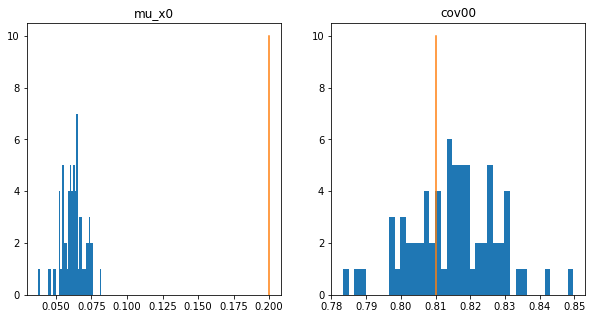

In [45]:
fig,ax = plt.subplots( ndim, 2, figsize=(10,5*ndim))

hbins=40

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    
    thisax.hist( fit_results_mean_val[i,:], bins=hbins)
    thisax.plot( [true_mu[i], true_mu[i]], [0,10])
    thisax.set_title( 'mu_x%d' % i )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    
    thisax.hist( fit_results_cov_val[i,i,:], bins=hbins)
    thisax.plot( [true_sig[i]*true_sig[i], true_sig[i]*true_sig[i]], [0,10])
    thisax.set_title( 'cov%d%d' % (i,i) )

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

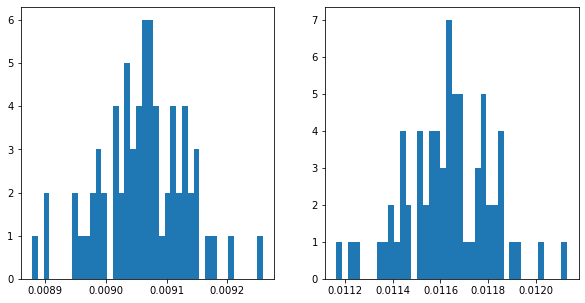

In [46]:
fig,ax = plt.subplots( ndim, 2, figsize=(10,5*ndim))

hbins=40

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    
    thisax.hist( fit_results_mean_err[i,:], bins=hbins)
    #thisax.plot( [true_mu[i], true_mu[i]], [0,10])
    #thisax.set_title( 'mu_x%d' % i )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    
    thisax.hist( fit_results_cov_err[i,i,:], bins=hbins)
    #thisax.plot( [true_sig[i]*true_sig[i], true_sig[i]*true_sig[i]], [0,10])
    #thisax.set_title( 'cov%d%d' % (i,i) )

plt.show

In [47]:
toy_fits_mu_rms = np.sqrt(np.var(fit_results_mean_val))
toy_fits_sig2_rms = np.sqrt(np.var(fit_results_cov_val))
toy_fits_mu_err_ave = np.average( fit_results_mean_err )
toy_fits_sig2_err_ave = np.average( fit_results_cov_err )

toy_fits_mu_ave = np.average( fit_results_mean_val )
toy_fits_sig2_ave = np.average( fit_results_cov_val )

print('\n\n')

print('  toy fits mu   ave. val  %7.4f,  true %7.4f' % (toy_fits_mu_ave, true_mu[0]))
print('  toy fits sig2 ave. val  %7.4f,  true %7.4f' % (toy_fits_sig2_ave, np.square(true_sig[0])))


print('\n\n')
print('  toy fits mu   RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_mu_rms, toy_fits_mu_err_ave))
print('  toy fits sig2 RMS:  %7.4f,  ave fit err %7.4f' % (toy_fits_sig2_rms, toy_fits_sig2_err_ave))
print('\n\n')





  toy fits mu   ave. val   0.0622,  true  0.2000
  toy fits sig2 ave. val   0.8153,  true  0.8100



  toy fits mu   RMS:   0.0081,  ave fit err  0.0091
  toy fits sig2 RMS:   0.0123,  ave fit err  0.0116



